# Spaceship titanic project

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!

### Import packages and data

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

data = pd.read_csv('train.csv')
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### Data cleaning

In [5]:
def data_clean(data):
    # Instead of dropping all NaN, we are going to replace NaN values with the mode of the column or with
    # a text Unknown for the name, which is not used in any model and hence is useless
    data['Name'] = data['Name'].fillna('Unknown')

    # Cabins: 5305 unique values; 80% of the entered values are unique
    # They are divided in P (port) and S (starboard)
    data['Cabin'] = data['Cabin'].str.split('/').str.get(-1)

    fill_mode_cols = ['HomePlanet','CryoSleep','Cabin','Destination','Age','VIP']
    price_mean_cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

    for col in fill_mode_cols:
        data[col] = data[col].fillna(data[col].mode()[0])
        
    # For the price columns, if passenger is in CryoSleep, then NaN values will become 0.
    for col in price_mean_cols:
        data[col] = np.where((data['CryoSleep'] == True) & (data[col].isnull()), 0, data[col])
        data[col] = np.where((data['CryoSleep'] == False) & (data[col].isnull()), data[col].mean(), data[col])

# Call function on dataset
data_clean(data)
# Confirm that NaN values are 0
data.isna().sum()



PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

**train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.

**CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

**Destination** - The planet the passenger will be debarking to.

**Age** - The age of the passenger.

**VIP** - Whether the passenger has paid for special VIP service during the voyage.

**RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

**Name** - The first and last names of the passenger.

**Transported**- Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

### Exploratory data analysis

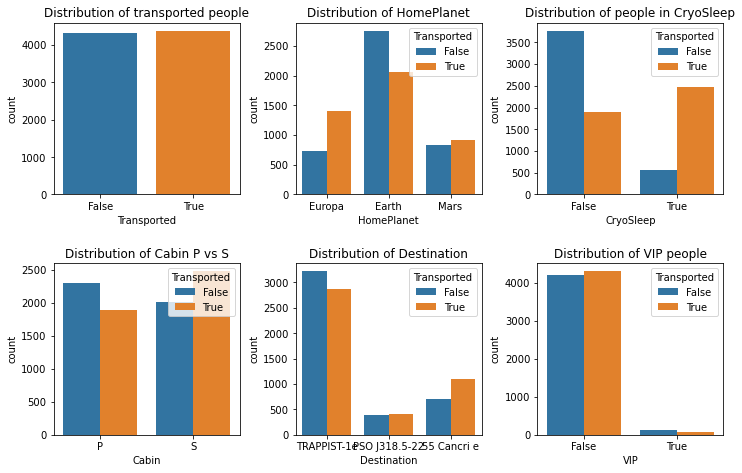

In [25]:
# Transported people is roughly 50-50
plt.figure(figsize=(12,12))

plt.subplot(3,3,1)
sns.countplot(data=data,x='Transported')
plt.title('Distribution of transported people')
# Distribution of HomePlanet
plt.subplot(3,3,2)
sns.countplot(data=data,x='HomePlanet',hue='Transported')
plt.title('Distribution of HomePlanet')
# Distribution of CryoSleep
plt.subplot(3,3,3)
sns.countplot(data=data,x='CryoSleep',hue='Transported')
plt.title('Distribution of people in CryoSleep')
# Distribution of P vs S cabin 
plt.subplot(3,3,4)
sns.countplot(data=data,x='Cabin',hue='Transported')
plt.title('Distribution of Cabin P vs S')
# Distribution of Destination
plt.subplot(3,3,5)
sns.countplot(data=data,x='Destination',hue='Transported')
plt.title('Distribution of Destination')
# Distribution of VIP people
plt.subplot(3,3,6)
sns.countplot(data=data,x='VIP',hue='Transported')
plt.title('Distribution of VIP people')

plt.subplots_adjust(hspace = 0.4, wspace=0.3)
plt.show()

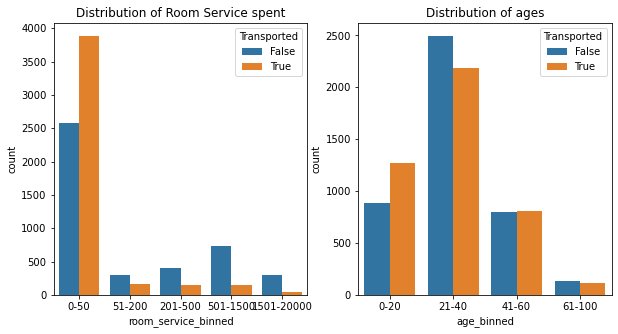

In [31]:
# Cutting the RoomService, FoodCourt, ShoppingMall, Spa, VRDeck into bins, so that it is possible to use them
# in the models
def bin_price_cols(data):
    cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
    binned_cols_names = ['room_service_binned','food_court_binned','shopping_binned','spa_binned','VR_binned']

    bins = [0, 50, 200, 500, 1500,20000]
    labels = ['0-50', '51-200', '201-500', '501-1500','1501-20000']
    for i in range(0,len(cols)):
        data[binned_cols_names[i]] = pd.cut(data[cols[i]], bins=bins, labels=labels, right=False)

# Calling the function
bin_price_cols(data)
    
# Cutting the age in bins as well
def bin_age_cols(data):
    bins = [0, 20, 40, 60, 100]
    labels = ['0-20', '21-40', '41-60', '61-100']
    data['age_binned'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)

# Calling the function
bin_age_cols(data)

# Plotting distribution of room service and age
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.countplot(data=data,x='room_service_binned',hue='Transported')
plt.title('Distribution of Room Service spent')

plt.subplot(1,2,2)
sns.countplot(data=data,x='age_binned',hue='Transported')
plt.title('Distribution of ages')

plt.show()

There are some interesting correlations. These columns will definitely be important in the model.

**Transported** Transported people are roughly 50% of the passengers.

**HomePlanet** Passengers from Europa were transported more often. For Mars, distribution is 50-50, whereas passengers from Earthers were more likely not to be transported.

**CryoSleep** People that were in Cryo sleep were much more likely to be transported than people who weren't.

**Port vs Seabord** Passengers in the S cabin were more likely to be transported. 

**Destination** Passengers going to 55 Cancri E were more likely to be transported. For the other 2 destinations, distribution was 50-50. 

**VIP** VIP people were quite few. In the VIP category, the majority was non-transported (by little). In the non-VIP, the majority was transported. Data is too little to be significant.

Money spent in **room service** or other services seem to correlate to whether or not passengers were transported. For example, people who spent between 0-200 in these services seem to be transported more often than not. Binning the dataframe will be useful because now the binned room service, SPA, etc. can be encoded and used in the models.

### Encoding variables for models

In [28]:
feature_cols = ['HomePlanet','CryoSleep','Cabin','Destination','VIP','age_binned',
                'room_service_binned','food_court_binned','shopping_binned','spa_binned','VR_binned']
features_train = data[feature_cols]
features_train = pd.get_dummies(features_train)

labels_train = data['Transported']

# Perform a train test split
X_train, X_test, y_train, y_test = train_test_split(features_train,labels_train,test_size=0.2,random_state=42)

### Getting the test dataset

In [30]:
# In this section, we re-do all the same procedures that we've done for training set, but 
# for the test.csv file

test_data = pd.read_csv('test.csv')
# Cleaning data with data_clean function
data_clean(test_data)
# Binning the data for price columns
bin_price_cols(test_data)
# Binning the ages 
bin_age_cols(test_data)

features_test = test_data[feature_cols]
features_test = pd.get_dummies(features_test)

## ML models

### KNN Model 

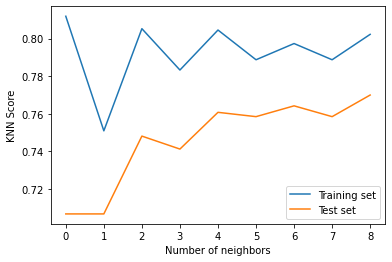

In [32]:
from sklearn.neighbors import KNeighborsClassifier

# Optimize neighbors number in KNN model
knn_scores_train = []
knn_scores_test = []
for n in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
    knn_scores_train.append(knn.score(X_train,y_train))
    knn_scores_test.append(knn.score(X_test,y_test))

plt.figure(1)
plt.plot(knn_scores_train)
plt.plot(knn_scores_test)
plt.xlabel('Number of neighbors')
plt.ylabel('KNN Score')
plt.legend(['Training set','Test set'])
plt.show()

### Random Forest Classifier

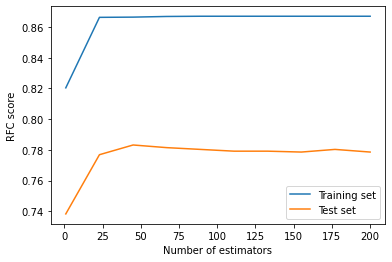

In [11]:
from sklearn.ensemble import RandomForestClassifier

rfc_scores_train = []
rfc_scores_test = []

for n in np.linspace(1,200,10,dtype=int):
    rfc = RandomForestClassifier(n_estimators=n).fit(X_train,y_train)
    rfc_scores_train.append(rfc.score(X_train,y_train))
    rfc_scores_test.append(rfc.score(X_test,y_test))
    
plt.figure(2)
plt.plot(np.linspace(1,200,10,dtype=int),rfc_scores_train)
plt.plot(np.linspace(1,200,10,dtype=int),rfc_scores_test)
plt.xlabel('Number of estimators')
plt.ylabel('RFC score')
plt.legend(['Training set','Test set'])
plt.show()

# 100 estimators (default) is a good number; now optimize depth

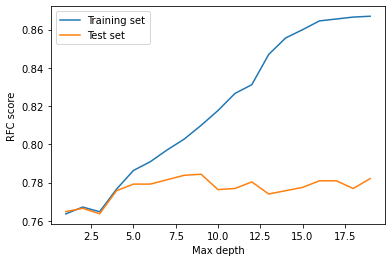

Max accuracy with Random Forest:
0.7843588269120184


In [12]:
rfc_scores_train = []
rfc_scores_test = []

for d in range(1,20):
    rfc = RandomForestClassifier(n_estimators = 70, max_depth = d).fit(X_train,y_train)
    rfc_scores_train.append(rfc.score(X_train,y_train))
    rfc_scores_test.append(rfc.score(X_test,y_test))
    
plt.figure(3)
plt.plot(range(1,20),rfc_scores_train)
plt.plot(range(1,20),rfc_scores_test)
plt.xlabel('Max depth')
plt.ylabel('RFC score')
plt.legend(['Training set','Test set'])
plt.show()

print('Max accuracy with Random Forest:')
print(max(rfc_scores_test))

## Predictions for submission

In [ ]:
rfc = RandomForestClassifier(n_estimators = 150, max_depth = 8).fit(X_train,y_train)

test_df = pd.DataFrame()
test_df['PassengerId'] = test_data['PassengerId']
test_df['Transported'] = rfc.predict(features_test)

test_df.to_csv(r'submission.csv', index=False, header=["PassengerId", "Transported"])